# Random Forest Notebook


In [1]:

from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import optuna
import json
import os
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
# Load dataset
df = pd.read_csv(r"C:\Users\aryan\Desktop\XAI\XAI_Models\time_series\dataset4\train.csv")

             Row ID        Order ID  Order Date   Ship Date       Ship Mode  \
count   9800.000000            9800        9800        9800            9800   
unique          NaN            4922        1230        1326               4   
top             NaN  CA-2018-100111  05/09/2017  26/09/2018  Standard Class   
freq            NaN              14          38          34            5859   
mean    4900.500000             NaN         NaN         NaN             NaN   
std     2829.160653             NaN         NaN         NaN             NaN   
min        1.000000             NaN         NaN         NaN             NaN   
25%     2450.750000             NaN         NaN         NaN             NaN   
50%     4900.500000             NaN         NaN         NaN             NaN   
75%     7350.250000             NaN         NaN         NaN             NaN   
max     9800.000000             NaN         NaN         NaN             NaN   

       Customer ID  Customer Name   Segment        

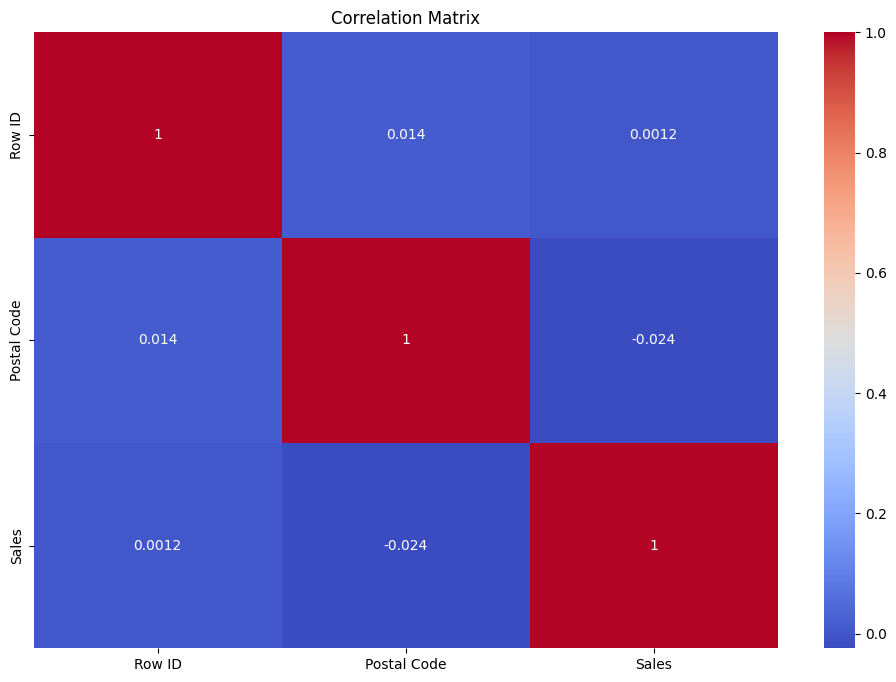

In [3]:
# Display basic statistics
print(df.describe(include='all'))

# Correlation matrix for numerical columns only
numerical_df = df.select_dtypes(include=['int64', 'float64'])
correlation_matrix = numerical_df.corr()
print(correlation_matrix)

# Plotting the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

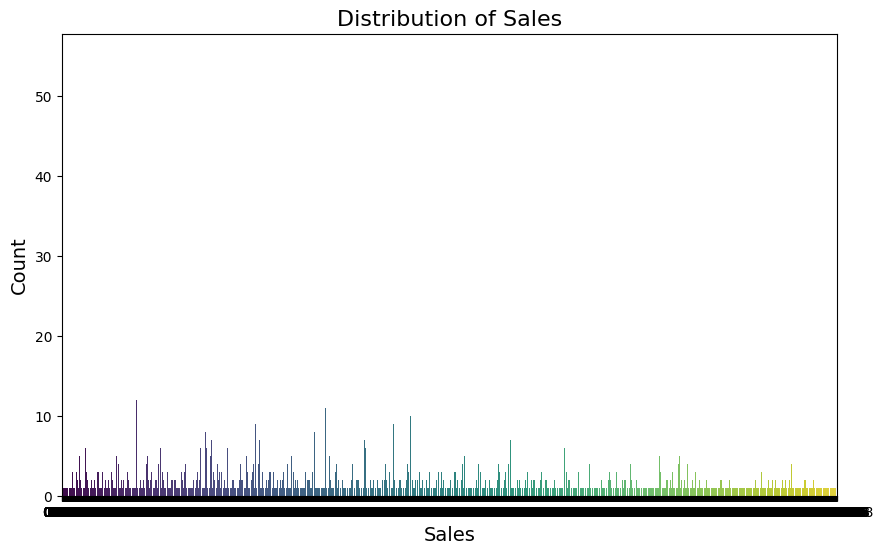

In [4]:

plt.figure(figsize=(10, 6))
sns.countplot(x='Sales', data=df, palette='viridis')
plt.title('Distribution of Sales', fontsize=16)
plt.xlabel('Sales', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

c:\Users\aryan\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


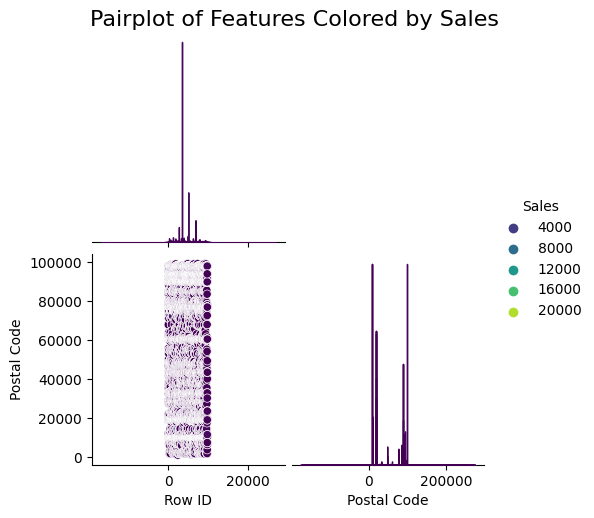

In [5]:
# Pairplot
sns.pairplot(df, hue='Sales', palette='viridis', corner=True)
plt.suptitle('Pairplot of Features Colored by Sales', y=1.02, fontsize=16)
plt.show()

In [6]:
df["Order Date"] = pd.to_datetime(df["Order Date"], format="%d/%m/%Y")
df = df.groupby("Order Date")["Sales"].sum().reset_index()
df = df.sort_values("Order Date")
df

,Order Date,Sales
0,2015-01-03,16.4480
1,2015-01-04,288.0600
2,2015-01-05,19.5360
3,2015-01-06,4407.1000
4,2015-01-07,87.1580
...,...,...
1225,2018-12-26,814.5940
1226,2018-12-27,177.6360
1227,2018-12-28,1657.3508
1228,2018-12-29,2915.5340


In [7]:
# Train-test split
test_size = int(len(df) * 0.2)
train, test = df.iloc[:-test_size].copy(), df.iloc[-test_size:].copy()


In [8]:
# Ensure "Sales" column exists in both train and test sets
if "Sales" not in train.columns or "Sales" not in test.columns:
    raise KeyError("The 'Sales' column is missing from train or test dataset!")

In [9]:
# Define numerical features
numerical_features = ["Sales"]
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features)
    ]
)

In [11]:
from sklearn.model_selection import cross_val_score

# Define the objective function for Optuna
def objective(trial):
    # Define the hyperparameters to tune
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    
    # Create the model with the suggested hyperparameters
    rf_regressor = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )

    # Create the pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', rf_regressor)
    ])

    # Perform cross-validation on the training data
    scores = cross_val_score(pipeline, train.drop(columns=['Order Date']), train['Sales'], cv=5, n_jobs=-1, scoring='neg_mean_absolute_error')
    return scores.mean()


In [12]:
# Check if the hyperparameters are already stored in the JSON file

model_name = 'Random Forest'
json_file = f'{model_name}.json'

if os.path.exists(json_file):
    with open(json_file, 'r') as file:
        best_params = json.load(file)
else:
    # Optimize the hyperparameters using Optuna
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=50)

    # Get the best hyperparameters
    best_params = study.best_params

    # Save the best hyperparameters to the JSON file
    with open(json_file, 'w') as file:
        json.dump(best_params, file)

# Print the best hyperparameters
print("Best Hyperparameters:", best_params)

# Remove the 'model' key from best_params if it exists
best_params.pop('model', None)

# Create the model with the best hyperparameters
rf_regressor = RandomForestRegressor(**best_params)

# Create the pipeline with the best hyperparameters
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', rf_regressor)
])


# Check if the JSON file contains hyperparameters
if 'n_estimators' in best_params:
    # Use the hyperparameters from the JSON file
    rf_regressor = RandomForestRegressor(**best_params)
else:
    # Optimize the hyperparameters using Optuna
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50)

    # Get the best hyperparameters
    best_params = study.best_params

    # Save the best hyperparameters to the JSON file
    with open(json_file, 'w') as file:
        json.dump(best_params, file)

    # Create the model with the best hyperparameters
    rf_regressor = RandomForestRegressor(**best_params)
    

[I 2025-02-26 16:53:28,250] A new study created in memory with name: no-name-17b14861-6099-4082-8dc6-f293126d5994


Best Hyperparameters: {'model': 'Random Forest'}


[I 2025-02-26 16:53:39,817] Trial 0 finished with value: -26.81206490343759 and parameters: {'n_estimators': 415, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 0 with value: -26.81206490343759.
[I 2025-02-26 16:53:42,002] Trial 1 finished with value: -87.22482346796455 and parameters: {'n_estimators': 275, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 1 with value: -87.22482346796455.
[I 2025-02-26 16:53:43,872] Trial 2 finished with value: -67.34889702983202 and parameters: {'n_estimators': 51, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 7}. Best is trial 1 with value: -87.22482346796455.
[I 2025-02-26 16:53:45,316] Trial 3 finished with value: -82.50064859541763 and parameters: {'n_estimators': 74, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 10}. Best is trial 1 with value: -87.22482346796455.
[I 2025-02-26 16:53:45,487] Trial 4 finished with value: -82.4822661553234 and parameters: {'n

In [13]:
# Create the pipeline with the best hyperparameters
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', rf_regressor)
])

# Define the features and target
X_train = train.drop(columns=['Order Date'])
y_train = train['Sales']

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Sales'])])),
                ('regressor',
                 RandomForestRegressor(max_depth=3, min_samples_leaf=9,
                                       min_samples_split=7,
                                       n_estimators=486))])

In [14]:
# Perform cross-validation on the training data
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, n_jobs=-1)
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())

Cross-validation scores: [0.74361268 0.98142183 0.99203648 0.9445847  0.93710471]
Mean cross-validation score: 0.9197520807673438


In [15]:
# Predict on the test data
y_pred = pipeline.predict(test)

In [16]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Calculate regression metrics
r2 = r2_score(test['Sales'], y_pred)
mae = mean_absolute_error(test['Sales'], y_pred)
mse = mean_squared_error(test['Sales'], y_pred)
rmse = mean_squared_error(test['Sales'], y_pred, squared=False)

print(f"R2 Score: {r2}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


R2 Score: 0.9771821725692122
Mean Absolute Error (MAE): 194.83471304135688
Mean Squared Error (MSE): 137273.13079731955
Root Mean Squared Error (RMSE): 370.50388769528394


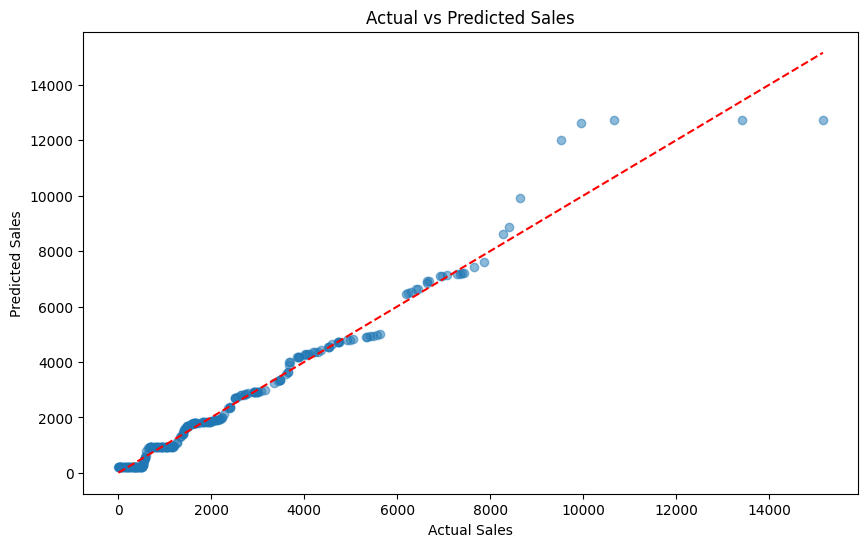

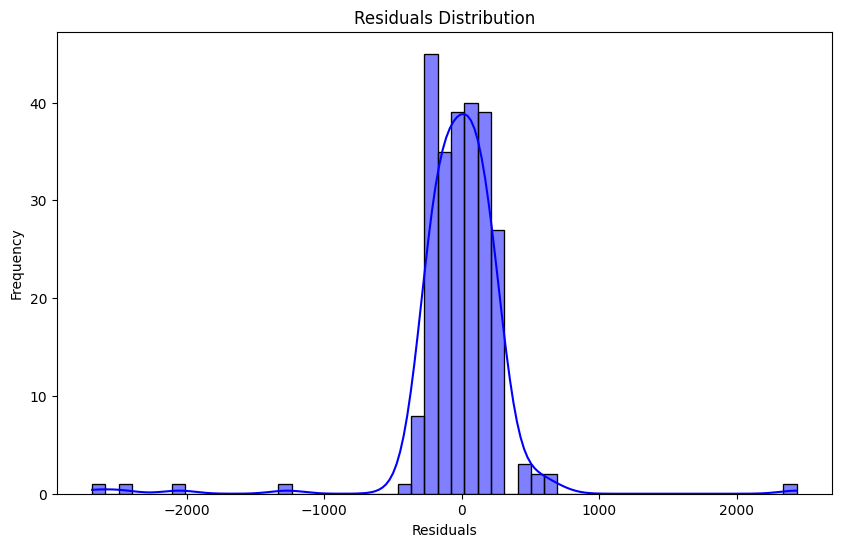

In [17]:
# Scatter plot of actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(test['Sales'], y_pred, alpha=0.5)
plt.plot([test['Sales'].min(), test['Sales'].max()], [test['Sales'].min(), test['Sales'].max()], 'r--')
plt.title('Actual vs Predicted Sales')
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.show()

# Residual plot
residuals = test['Sales'] - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='blue')
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

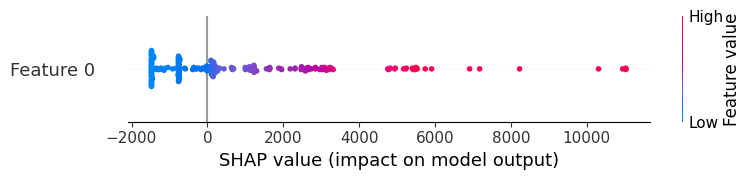

In [19]:
# Define X_test and y_test
X_test = test.drop(columns=['Order Date'])
y_test = test['Sales']

# Transform X_test using the preprocessor
X_test_transformed = preprocessor.transform(X_test)

# Calculate SHAP values
explainer = shap.TreeExplainer(rf_regressor)
shap_values = explainer.shap_values(X_test_transformed)

# Explainability using SHAP summary plot
shap.summary_plot(shap_values, X_test_transformed)

In [21]:
# Store metrics
metrics_data = []
# Append results
metrics_data.append({
    "Model": model_name,
    "R2_Score": r2,
    "Mean Absolute Error": mae,
    "Mean Squared Error": mse,
    "Root Mean Squared Error": rmse
})

# Save metrics to a DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Save to CSV
metrics_df.to_csv("random_forest_metrics.csv", index=False)

In [22]:
import joblib

# Assuming the model is trained in your .ipynb session and available in memory
# Replace 'model' with the actual variable holding your trained model
joblib.dump(rf_regressor, 'random_forest.pkl')

print("Model saved successfully as 'random_forest.pkl'")


Model saved successfully as 'random_forest.pkl'
